# Preserving spatial derivatives with safeguards

In this example, which has been adpted from the ZFP evaluation at <https://computing.llnl.gov/projects/zfp/zfp-and-derivatives>, we compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the second derivative of the data, and apply safeguards to guarantee that spatial derivatives are preserved.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
x = y = np.linspace(-1, 1, 1024)
Y, X = np.meshgrid(y, x, indexing="ij")

In [3]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dy, dx

(np.float64(0.0019550342130987275), np.float64(0.0019550342130987275))

In [4]:
# compute the Laplacian DU for a 2D field U using numpy.gradient
def compute_DU(U):
    return np.gradient(
        np.gradient(U, y, axis=0, edge_order=1), y, axis=0, edge_order=1
    ) + np.gradient(np.gradient(U, x, axis=1, edge_order=1), x, axis=1, edge_order=1)

In [5]:
# plot the Laplacian DU for a 2D field my_U
def plot_DU(my_U, cr, ax, title, transform=None, my_DU=None):
    show_err = my_DU is None

    if my_DU is None:
        my_DU = compute_DU(my_U)

    DU = compute_DU(U)

    if transform is not None:
        DU = transform(DU)
        my_DU = transform(my_DU)

    vmin = np.nanmin(DU)
    vmax = np.nanmax(DU)

    err_U = np.amax(np.abs(my_U - U))
    err_DU = np.amax(np.abs(my_DU - DU))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    if show_err:
        ax.set_title(
            f"{title}\n"
            rf"$\epsilon_{{\hat{{u}}}}$={err_U:.02}  $\epsilon_{{\Delta \hat{{u}}}}$={err_DU:.02}"
        )
    else:
        ax.set_title(f"{title}\n")

    # create a colourmap that includes the entire finite range of my_DU but
    #  assigns colours based on the range of DU to ensure consistent colours
    cx = np.linspace(
        (
            np.minimum(np.amin(np.nan_to_num(my_DU, nan=0, posinf=0, neginf=0)), vmin)
            - vmin
        )
        / (vmax - vmin),
        (
            np.maximum(vmax, np.amax(np.nan_to_num(my_DU, nan=0, posinf=0, neginf=0)))
            - vmin
        )
        / (vmax - vmin),
        256,
    )
    cmap = LinearSegmentedColormap.from_list("RdBu_r_ext", plt.get_cmap("RdBu_r")(cx))

    ax.fill_between(
        [0, 1],
        [1, 1],
        hatch="XX",
        edgecolor="magenta",
        facecolor="lavenderblush",
        transform=ax.transAxes,
        zorder=-13,
    )
    im = ax.imshow(my_DU, cmap=cmap, origin="lower", extent=(-1, 1, -1, 1), zorder=-12)

    ax.contour(
        X,
        Y,
        my_DU,
        levels=10,
        colors="lightgrey",
        vmin=vmin,
        vmax=vmax,
        alpha=0.25,
        zorder=-11,
    )
    ax.set_rasterization_zorder(-10)
    ax.set_aspect("equal")

    if show_err:
        t = ax.text(
            0.95,
            0.95,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="black"))

    ax.get_figure().colorbar(im, cax=cax, orientation="vertical")

## Example 1: $u(x, y) = {(x^2 + y^2)}^{3 \mathbin{/} 2} \mathbin{/} 9$

The Laplacian of $u$ is $\Delta u = \sqrt{x^2 + y^2}$.

We evaluate the Laplacian numerically on the original $u$ and the compressed $\hat{u}$s by twice applying the `np.gradient` function.

In [6]:
U = np.power(X**2 + Y**2, 3 / 2) / 9

In [7]:
# analytical solution on uncompressed
DU = np.sqrt(X**2 + Y**2)

In [8]:
# absolute error bound for error-bounded lossy compression
eb_abs = 1e-6

In [9]:
# compressed with ZFP
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

U_zfp_enc = zfp.encode(U)
U_zfp = zfp.decode(U_zfp_enc)
U_zfp_cr = U.nbytes / U_zfp_enc.nbytes

In [10]:
# compressed with SZ3
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

U_sz3_enc = sz3.encode(U)
U_sz3 = sz3.decode(U_sz3_enc)
U_sz3_cr = U.nbytes / U_sz3_enc.nbytes

In [11]:
# compressed with SPERR
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

U_sperr_enc = sperr.encode(U)
U_sperr = sperr.decode(U_sperr_enc)
U_sperr_cr = U.nbytes / U_sperr_enc.nbytes

In [12]:
# compressed with the safeguards with an absolute error bound
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

sg_abs = SafeguardsCodec(
    codec=zero,
    safeguards=[
        dict(kind="eb", type="abs", eb=eb_abs),
    ],
)

U_sg_abs_enc = sg_abs.encode(U)
U_sg_abs = sg_abs.decode(U_sg_abs_enc)
U_sg_abs_cr = U.nbytes / np.asarray(U_sg_abs_enc).nbytes

In [13]:
U_sg_qoi = dict()
U_sg_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_qoi = SafeguardsCodec(
        codec=codec,
        # numpy.gradient uses central differences on the inner points and
        #  forward/backward differences on the boundary
        # with constant spacing, central differences with edge boundaries are
        #  equivalent
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                (
                    finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_spacing=c["dy"]) +
                    finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_spacing=c["dx"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=1, after=1, boundary="edge"),
                    dict(axis=1, before=1, after=1, boundary="edge"),
                ],
                type="abs",
                eb=0.1,
            ),
        ],
        fixed_constants=dict(dx=dx, dy=dy),
    )

    U_sg_qoi_enc = codec_sg_qoi.encode(U)
    U_sg_qoi[codec.codec_id] = codec_sg_qoi.decode(U_sg_qoi_enc)
    U_sg_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_qoi_enc).nbytes

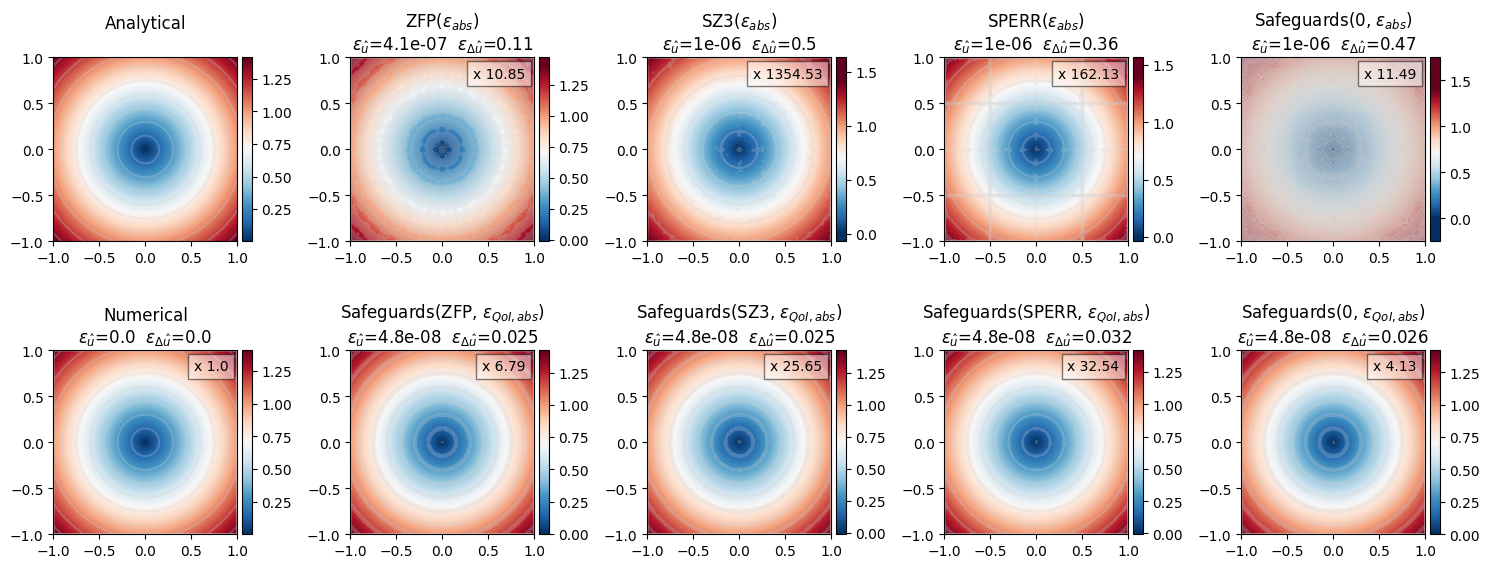

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

plot_DU(U, 1.0, axs[0, 0], "Analytical", my_DU=DU)
plot_DU(U_zfp, U_zfp_cr, axs[0, 1], r"ZFP($\epsilon_{abs}$)")
plot_DU(U_sz3, U_sz3_cr, axs[0, 2], r"SZ3($\epsilon_{abs}$)")
plot_DU(U_sperr, U_sperr_cr, axs[0, 3], r"SPERR($\epsilon_{abs}$)")
plot_DU(U_sg_abs, U_sg_abs_cr, axs[0, 4], r"Safeguards(0, $\epsilon_{abs}$)")

plot_DU(U, 1.0, axs[1, 0], "Numerical")
plot_DU(
    U_sg_qoi["zfp.rs"],
    U_sg_qoi_cr["zfp.rs"],
    axs[1, 1],
    r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
)
plot_DU(
    U_sg_qoi["sz3.rs"],
    U_sg_qoi_cr["sz3.rs"],
    axs[1, 2],
    r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
)
plot_DU(
    U_sg_qoi["sperr.rs"],
    U_sg_qoi_cr["sperr.rs"],
    axs[1, 3],
    r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
)
plot_DU(
    U_sg_qoi["zero"],
    U_sg_qoi_cr["zero"],
    axs[1, 4],
    r"Safeguards(0, $\epsilon_{QoI,abs}$)",
)

plt.tight_layout()

plt.savefig("derivative-radial.pdf", dpi=300)

plt.show()

## Example 2: $u(x, y) = e^{4 x + 3 y}$

The Laplacian of $u$ is $\Delta u = 25 u$.

We plot the natural logarithm of the Laplacian.

In [15]:
U = np.exp(4 * X + 3 * Y)

In [16]:
# analytical solution on uncompressed
DU = U * 25

In [17]:
# absolute error bound for error-bounded lossy compression
eb_abs = 1e-2

In [18]:
# compressed with ZFP
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

U_zfp_enc = zfp.encode(U)
U_zfp = zfp.decode(U_zfp_enc)
U_zfp_cr = U.nbytes / U_zfp_enc.nbytes

In [19]:
# compressed with SZ3
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

U_sz3_enc = sz3.encode(U)
U_sz3 = sz3.decode(U_sz3_enc)
U_sz3_cr = U.nbytes / U_sz3_enc.nbytes

In [20]:
# compressed with SPERR
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

U_sperr_enc = sperr.encode(U)
U_sperr = sperr.decode(U_sperr_enc)
U_sperr_cr = U.nbytes / U_sperr_enc.nbytes

In [21]:
# compressed with the safeguards with an absolute error bound
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

sg_abs = SafeguardsCodec(
    codec=zero,
    safeguards=[
        dict(kind="eb", type="abs", eb=eb_abs),
    ],
)

U_sg_abs_enc = sg_abs.encode(U)
U_sg_abs = sg_abs.decode(U_sg_abs_enc)
U_sg_abs_cr = U.nbytes / np.asarray(U_sg_abs_enc).nbytes

In [22]:
U_sg_qoi = dict()
U_sg_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the log of the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_qoi = SafeguardsCodec(
        codec=codec,
        # numpy.gradient uses central differences on the inner points and
        #  forward/backward differences on the boundary
        # with arbitrary grid-based spacing and an edge boundary, the central
        #  finite differences on the boundary will be invalid, since the
        #  edge-extended point has the same coordinate as the edge, which the
        #  safeguards exploit to allow any inputs that still produce an invalid
        #  value
        # for arbitrary grid-based spacing, we therefore have to replicate
        #  numpy.gradient more closely and additionally safeguards forward/
        #  backward differences, with the valid boundary condition, that apply
        #  on the boundary
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=1, after=1, boundary="valid"),
                    dict(axis=1, before=1, after=1, boundary="valid"),
                ],
                type="abs",
                eb=1.0,
            ),
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=1, type=-1, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=1, type=-1, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=2, after=0, boundary="valid"),
                    dict(axis=1, before=2, after=0, boundary="valid"),
                ],
                type="abs",
                eb=1.0,
            ),
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=1, type=+1, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=1, type=+1, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=0, after=2, boundary="valid"),
                    dict(axis=1, before=0, after=2, boundary="valid"),
                ],
                type="abs",
                eb=1.0,
            ),
        ],
        fixed_constants=dict(X=X, Y=Y),
    )

    U_sg_qoi_enc = codec_sg_qoi.encode(U)
    U_sg_qoi[codec.codec_id] = codec_sg_qoi.decode(U_sg_qoi_enc)
    U_sg_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_qoi_enc).nbytes

/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_2757/2059033296.py:12: RuntimeWarning: divide by zero encountered in log
  my_DU = transform(my_DU)
/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_2757/2059033296.py:12: RuntimeWarning: invalid value encountered in log
  my_DU = transform(my_DU)


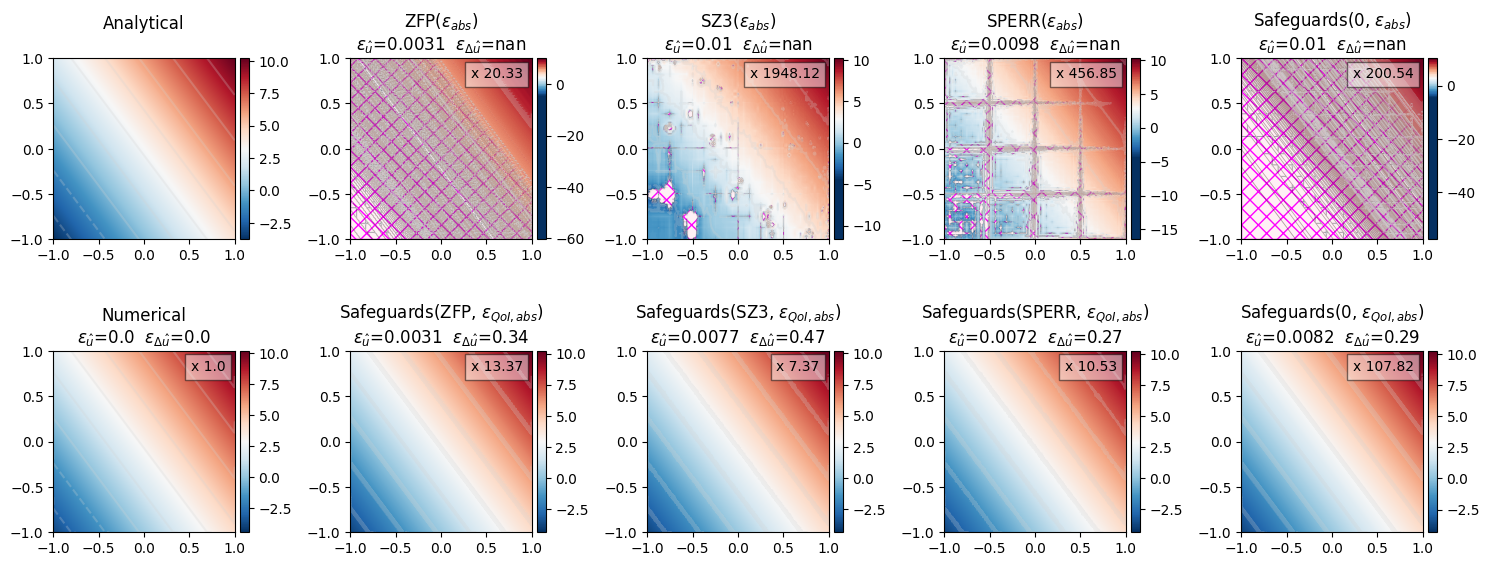

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

plot_DU(U, 1.0, axs[0, 0], "Analytical", my_DU=DU, transform=np.log)
plot_DU(U_zfp, U_zfp_cr, axs[0, 1], r"ZFP($\epsilon_{abs}$)", transform=np.log)
plot_DU(U_sz3, U_sz3_cr, axs[0, 2], r"SZ3($\epsilon_{abs}$)", transform=np.log)
plot_DU(U_sperr, U_sperr_cr, axs[0, 3], r"SPERR($\epsilon_{abs}$)", transform=np.log)
plot_DU(
    U_sg_abs,
    U_sg_abs_cr,
    axs[0, 4],
    r"Safeguards(0, $\epsilon_{abs}$)",
    transform=np.log,
)

plot_DU(U, 1.0, axs[1, 0], "Numerical", transform=np.log)
plot_DU(
    U_sg_qoi["zfp.rs"],
    U_sg_qoi_cr["zfp.rs"],
    axs[1, 1],
    r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
    transform=np.log,
)
plot_DU(
    U_sg_qoi["sz3.rs"],
    U_sg_qoi_cr["sz3.rs"],
    axs[1, 2],
    r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
    transform=np.log,
)
plot_DU(
    U_sg_qoi["sperr.rs"],
    U_sg_qoi_cr["sperr.rs"],
    axs[1, 3],
    r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
    transform=np.log,
)
plot_DU(
    U_sg_qoi["zero"],
    U_sg_qoi_cr["zero"],
    axs[1, 4],
    r"Safeguards(0, $\epsilon_{QoI,abs}$)",
    transform=np.log,
)

plt.tight_layout()

plt.savefig("derivative-log-exp.pdf", dpi=300)

plt.show()